## Aggregating vs averaging variant frequencies within groups
___

Load necessary packages and temperature experiment data file 

In [32]:
import pandas as pd
import numpy as np
from pi_for_temperature_notebook import *
import statsmodels.api as sm
import statsmodels.formula.api as sf
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("variant-calls_temperature-expt_2020-04-07_tables.csv", header=0, index_col=0)

C:\Users\Erik\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The above errors can be ignored because they arise from 32$ ^{o} $ data, which we will filter out. Also filter out variants that are represented in only one technical replicate, as well as variants that do not have a frequency of 3% or more in at least one technical replicate.

In [3]:
data_no_32 = data.loc[data.temperature != 32]
data_no_32_both_present = data_no_32.dropna(subset=['ADReplicateA','ADReplicateB'])
filtered_data = pd.concat([data_no_32_both_present.loc[data_no_32_both_present.freqPropReplicateA >= 0.3],
                           data_no_32_both_present.loc[data_no_32_both_present.freqPropReplicateB >= 0.03]]).drop_duplicates()


Previous analyses has shown a tight correlation between technical replicates, as expected by the manner of the replication. Aggregate technical replicate read counts to get a single variant frequency for each sequence variant.

In [4]:
#set new DP and AD columns with aggregate of Replicate RD and AD values
#This aggregates only counts of reads that passed VarScan filters 
filtered_data['DP'] = filtered_data['ADReplicateA'] + filtered_data['ADReplicateB'] +filtered_data['RDReplicateA'] + filtered_data['RDReplicateB']
filtered_data['AD'] = filtered_data['ADReplicateA'] + filtered_data['ADReplicateB']

#calculate frequency of aggregated read counts
filtered_data['freqProp'] = filtered_data['AD'] / filtered_data['DP']


Add factor data for lineage, species, and segment (for DNA-A and DNA-B segment designations)

In [5]:
#lineage: set to 0 then assign each unique lineage to an unique integer
filtered_data['lineage_factor'] = 0
j = 0
for lineage in filtered_data.lineage.unique():
    filtered_data.loc[filtered_data.lineage == lineage,['lineage_factor']] = j
    j += 1

#species: Set ACMV = 0 and EACMCV = 1
filtered_data['species'] = 0
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-A',['species']] = 1
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-B',['species']] = 1

#segment: Set DNA-A = 0 and DNA-B = 1
filtered_data['segment'] = 0
filtered_data.loc[filtered_data.chrom == 'ACMV DNA-B',['segment']] = 1
filtered_data.loc[filtered_data.chrom == 'EACMCV DNA-B',['segment']] = 1


Load the options for calculation of pi then print them out.

In [6]:
options = get_temp_args()
print(options)

{'group': 'index', 'reference': 'ref', 'position': 'pos', 'alternate': 'alt', 'coverage': False, 'frequency': 'freqProp', 'perSite': True, 'sizeCorrection': False, 'length': 2800, 'sampling_variance': False}


In [7]:
#set new values for options as necessary
options['coverage'] = 'DP'
options['perSite'] = False

In [8]:
pis = {}

grouped_data = filtered_data.groupby(by=['passage','temperature','species','segment','lineage_factor','plantID'])
    
for group in grouped_data:
    
        try:
            N_samples = int(group[1][options['coverage']].mean())
        except:
            N_samples = False
              
        pis[group[0]] = pi(pi_data=group[1],
            sites=(1, group[1][options['position']].max()),
            N_samples=N_samples,
            pos_id=options['position'],
            Reference=options['reference'],
            Alternate=options['alternate'],
            frequency=options['frequency'],
            correction=options['sizeCorrection'],
            per_site=options['perSite'],
            sampling_variance=options['sampling_variance'],
            length=options['length'])


In [9]:
pi_df = pd.DataFrame(columns=['pi',
                      'passage',
                      'temperature',
                      'species',
                      'segment',
                      'lineage_factor',
                      'plantID'])

pi = []
temperature = []
passage = []
species = []
segment = []
lineage_factor = []
plantID = []

for key in pis.keys():
    pi.append(pis[key][0])
    passage.append(key[0])
    temperature.append(key[1])
    species.append(key[2])
    segment.append(key[3])
    lineage_factor.append(key[4])
    plantID.append(key[5])
    
    
pi_df.pi = pi
pi_df.passage = passage
pi_df.temperature = temperature
pi_df.species = species
pi_df.segment = segment
pi_df.lineage_factor = lineage_factor
pi_df.plantID = plantID

In [10]:
lm = sf.ols('pi ~ passage + temperature + (C(species)/C(segment)) + C(lineage_factor)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary2())

Least squares summary:
                      Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.306   
Dependent Variable:      pi                  AIC:                   266.8368
Date:                    2020-06-16 13:18    BIC:                   288.8837
No. Observations:        67                  Log-Likelihood:        -123.42 
Df Model:                9                   F-statistic:           32.40   
Df Residuals:            57                  Prob (F-statistic):    6.29e-20
R-squared:               0.400               Scale:                 2.7398  
----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------
Intercept                     -0.0164   0.1029 -0.1589 0.8737 -0.2180 0.1853
C(species)[T.1]               -0.6892   0.6913 -0.9969 0.3188 -2.0442 0.6657

There is strong multicollinearity in the model. Let's inspect a few variables

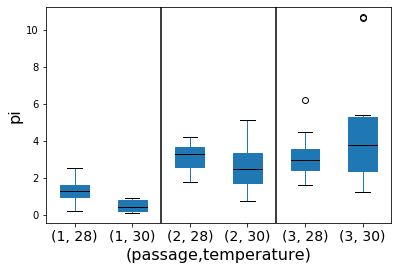

In [11]:
p = pi_df.boxplot(column='pi',
             by=['passage','temperature'],
             patch_artist=True,
             grid=False,
             return_type='dict')

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,temperature)',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5,4.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

Looks like we could omit temperature from the model.

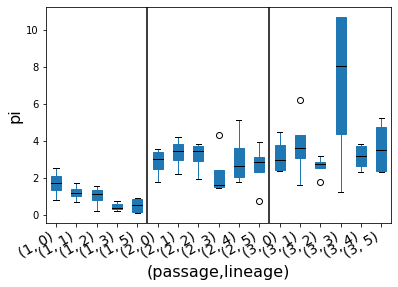

In [12]:
p = pi_df.boxplot(column='pi',
             by=['passage','lineage_factor'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,lineage)',fontsize=16)
ylim = plt.ylim()

plt.xticks(fontsize=14,ha='right')
plt.suptitle('')
plt.title('')

ylim = plt.ylim()

plt.vlines(x=[5.5,11.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

for median in p[0]['medians']:
    median.set_color('k')

Looks like we can onit lineage from the model as well.

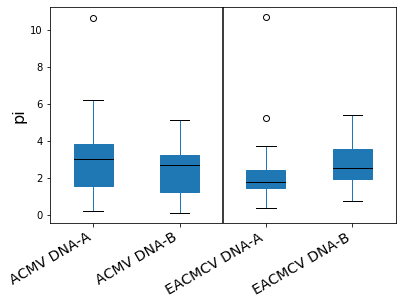

In [13]:
p = pi_df.boxplot(column='pi',
             by=['species','segment'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks([1,2,3,4],
           ['ACMV DNA-A','ACMV DNA-B','EACMCV DNA-A','EACMCV DNA-B'],
           fontsize=14,
           ha='right')
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

Let's remove temperature and lineage from the model

In [14]:
lm = sf.ols('pi ~ passage + (C(species)/C(segment)) ',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     10.15
Date:                Tue, 16 Jun 2020   Prob (F-statistic):           2.20e-06
Time:                        13:19:00   Log-Likelihood:                -125.66
No. Observations:                  67   AIC:                             261.3
Df Residuals:                      62   BIC:                             272.3
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

Looks like a moderate improvement gained by reducing variables. Let's aggregate the data to reduce noise.

In [15]:
def aggregate_groups(data,columns,DP='DP',AD='AD',freq='freqProp'):
    
    aggregated_data = data.groupby(by=columns).agg(sum)
    aggregated_data[freq] = aggregated_data[AD] / aggregated_data[DP]
    
    return aggregated_data

In [16]:
agg_data = aggregate_groups(filtered_data,['species','segment','pos','alt','passage','ref'])

agg_data.reset_index(inplace=True)
agg_data['pos'] = agg_data.pos.astype(int)   

agg_data = agg_data.groupby(by=['species','segment','passage'])

In [19]:
agg_pis = {}
    
for group in agg_data:
    
        try:
            N_samples = int(group[1][options['coverage']].mean())
        except:
            N_samples = False
              
        agg_pis[group[0]] = pi(pi_data=group[1],
            sites=(1, group[1][options['position']].max()),
            N_samples=N_samples,
            pos_id=options['position'],
            Reference=options['reference'],
            Alternate=options['alternate'],
            frequency=options['frequency'],
            correction=options['sizeCorrection'],
            per_site=options['perSite'],
            sampling_variance=options['sampling_variance'],
            length=options['length'])


In [20]:
agg_pi_df = pd.DataFrame(columns=['pi',
                      'passage',
                      'species',
                      'segment'])

pi = []
passage = []
species = []
segment = []

for key in agg_pis.keys():
    pi.append(agg_pis[key][0])
    passage.append(key[2])
    species.append(key[0])
    segment.append(key[1])    
    
agg_pi_df.pi = pi
agg_pi_df.passage = passage
agg_pi_df.species = species
agg_pi_df.segment = segment


In [21]:
lm = sf.ols('pi ~ passage + C(species)/C(segment)',data=agg_pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary())

table = sm.stats.anova_lm(lm)
print(table)

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     15.28
Date:                Tue, 16 Jun 2020   Prob (F-statistic):            0.00144
Time:                        13:19:47   Log-Likelihood:                -31.986
No. Observations:                  12   AIC:                             73.97
Df Residuals:                       7   BIC:                             76.40
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

C:\Users\Erik\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [22]:
for ind in table.index:
    
    print("{} explains \t {:.2%} of variance".format(ind,table.loc[ind,'sum_sq'] / table.sum_sq.sum()))

C(species) explains 	 1.02% of variance
C(species):C(segment) explains 	 3.71% of variance
passage explains 	 78.01% of variance
Residual explains 	 17.26% of variance


### Now let's look at averaging pi within groups

Let's start with the raw data again, and use the mean between technical replicates as a single frequency per variant. `freqPropMeanNoNA` already exists as the mean of ReplicateA and ReplicateB frequencies, so we can use `filtered_data` as-is. We'll first calculate pi from the average values and inspect the analysis results.

In [25]:
pis = {}

#set the frequency for column name of the mean of the replicates
options['frequency'] = 'freqPropMeanNoNA'

grouped_data = filtered_data.groupby(by=['passage','temperature','species','segment','lineage_factor','plantID'])
    
for group in grouped_data:
    
        try:
            N_samples = int(group[1][options['coverage']].mean())
        except:
            N_samples = False
              
        pis[group[0]] = pi(pi_data=group[1],
            sites=(1, group[1][options['position']].max()),
            N_samples=N_samples,
            pos_id=options['position'],
            Reference=options['reference'],
            Alternate=options['alternate'],
            frequency=options['frequency'],
            correction=options['sizeCorrection'],
            per_site=options['perSite'],
            sampling_variance=options['sampling_variance'],
            length=options['length'])

pi_df = pd.DataFrame(columns=['pi',
                      'passage',
                      'temperature',
                      'species',
                      'segment',
                      'lineage_factor',
                      'plantID'])

pi = []
temperature = []
passage = []
species = []
segment = []
lineage_factor = []
plantID = []

for key in pis.keys():
    pi.append(pis[key][0])
    passage.append(key[0])
    temperature.append(key[1])
    species.append(key[2])
    segment.append(key[3])
    lineage_factor.append(key[4])
    plantID.append(key[5])
    
    
pi_df.pi = pi
pi_df.passage = passage
pi_df.temperature = temperature
pi_df.species = species
pi_df.segment = segment
pi_df.lineage_factor = lineage_factor
pi_df.plantID = plantID        

lm = sf.ols('pi ~ passage + temperature + (C(species)/C(segment)) + C(lineage_factor)',data=pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm.summary2())

Least squares summary:
                      Results: Ordinary least squares
Model:                   OLS                 Adj. R-squared:        0.306   
Dependent Variable:      pi                  AIC:                   266.7164
Date:                    2020-06-16 13:20    BIC:                   288.7634
No. Observations:        67                  Log-Likelihood:        -123.36 
Df Model:                9                   F-statistic:           32.43   
Df Residuals:            57                  Prob (F-statistic):    6.17e-20
R-squared:               0.400               Scale:                 2.7349  
----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------
Intercept                     -0.0162   0.1028 -0.1572 0.8751 -0.2177 0.1853
C(species)[T.1]               -0.6877   0.6906 -0.9958 0.3194 -2.0412 0.6659

Now plot data

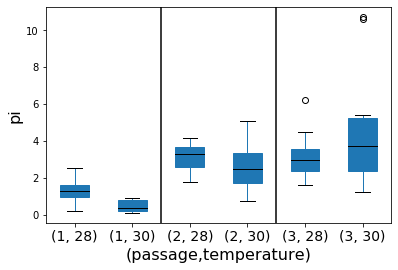

In [26]:
p = pi_df.boxplot(column='pi',
             by=['passage','temperature'],
             patch_artist=True,
             grid=False,
             return_type='dict')

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,temperature)',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5,4.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks(fontsize=14)
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

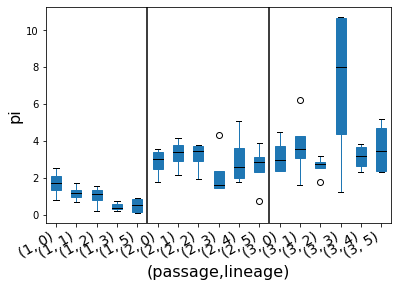

In [27]:
p = pi_df.boxplot(column='pi',
             by=['passage','lineage_factor'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('(passage,lineage)',fontsize=16)
ylim = plt.ylim()

plt.xticks(fontsize=14,ha='right')
plt.suptitle('')
plt.title('')

ylim = plt.ylim()

plt.vlines(x=[5.5,11.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

for median in p[0]['medians']:
    median.set_color('k')

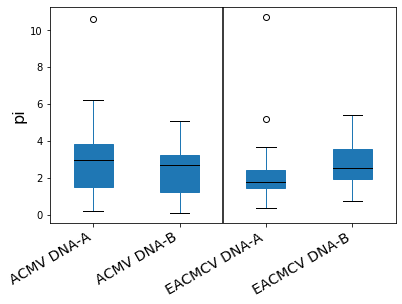

In [28]:
p = pi_df.boxplot(column='pi',
             by=['species','segment'],
             patch_artist=True,
             grid=False,
             return_type='dict',
             rot=30)

plt.ylabel('pi',fontsize=16)
plt.xlabel('',fontsize=16)
ylim = plt.ylim()

plt.vlines(x=[2.5],ymin=ylim[0],ymax=ylim[1])
plt.ylim(ylim)

plt.xticks([1,2,3,4],
           ['ACMV DNA-A','ACMV DNA-B','EACMCV DNA-A','EACMCV DNA-B'],
           fontsize=14,
           ha='right')
plt.suptitle('')
plt.title('')

for median in p[0]['medians']:
    median.set_color('k')

Looks like there is no great difference in averaging or aggregating technical replicate data.

In [29]:
def average_groups(data,columns):
    
    #this function groups the data by `columns` and aggregates other columns by 
    #    returning the mean of the rows within each group
    averaged_data = data.groupby(by=columns).agg(np.mean)
    
    return averaged_data

In [33]:
#average frequencies of identical variants across lineages within each group
avg_data = average_groups(filtered_data,['species','segment','pos','alt','passage','ref'])

#reset the index and retype position columns `pos` as integer
avg_data.reset_index(inplace=True)
avg_data['pos'] = avg_data.pos.astype(int)   

#group the data by species, segment, and passage, then caculate pi for each group
avg_data = avg_data.groupby(by=['species','segment','passage'])

avg_pis = {}
    
for group in avg_data:
    
        try:
            N_samples = int(group[1][options['coverage']].mean())
        except:
            N_samples = False
              
        avg_pis[group[0]] = pi(pi_data=group[1],
            sites=(1, group[1][options['position']].max()),
            N_samples=N_samples,
            pos_id=options['position'],
            Reference=options['reference'],
            Alternate=options['alternate'],
            frequency=options['frequency'],
            correction=options['sizeCorrection'],
            per_site=options['perSite'],
            sampling_variance=options['sampling_variance'],
            length=options['length'])

#generate a dataframe from the group data (stored in `avg_data` keys) and pi values (stored in `avg_pis` values)
avg_pi_df = pd.DataFrame(columns=['pi',
                      'passage',
                      'species',
                      'segment'])

pi = []
passage = []
species = []
segment = []

for key in avg_pis.keys():
    pi.append(avg_pis[key][0])
    passage.append(key[2])
    species.append(key[0])
    segment.append(key[1])    
    
avg_pi_df.pi = pi
avg_pi_df.passage = passage
avg_pi_df.species = species
avg_pi_df.segment = segment        

In [34]:
lm_avg = sf.ols('pi ~ passage + C(species)/C(segment)',data=avg_pi_df).fit(cov_type='HC1')
print("Least squares summary:")
print(lm_avg.summary())

table_avg = sm.stats.anova_lm(lm_avg)
print(table)

Least squares summary:
                            OLS Regression Results                            
Dep. Variable:                     pi   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     15.38
Date:                Tue, 16 Jun 2020   Prob (F-statistic):            0.00141
Time:                        13:21:01   Log-Likelihood:                -32.115
No. Observations:                  12   AIC:                             74.23
Df Residuals:                       7   BIC:                             76.65
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

C:\Users\Erik\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [35]:
print("Aggregated groups:")
for ind in table.index:
    
    print("{} explains \t {:.2%} of variance".format(ind,table.loc[ind,'sum_sq'] / table.sum_sq.sum()))

print("\nAveraged groups:")
for ind in table.index:
    
    print("{} explains \t {:.2%} of variance".format(ind,table_avg.loc[ind,'sum_sq'] / table_avg.sum_sq.sum()))

Aggregated groups:
C(species) explains 	 1.02% of variance
C(species):C(segment) explains 	 3.71% of variance
passage explains 	 78.01% of variance
Residual explains 	 17.26% of variance

Averaged groups:
C(species) explains 	 1.05% of variance
C(species):C(segment) explains 	 3.47% of variance
passage explains 	 78.06% of variance
Residual explains 	 17.42% of variance


### Looks there is not a great difference between averaging or aggregating technical replicate data.